# Milestone 4 - Evaluating the model

## Evaluate the Trained Model on the Test Set

**Objective**

1. Using the feature extraction from the previous milestone, compute features for all videos in the test set and save them in HDF5 files. Make sure the features for genuine and Deepfake videos are saved in a separate folders, so you can know if the feature comes from original genuine video or Deepfake.

2. Using the pre-trained linear SVM model, apply it to the features in the test set.



Workflow

1. Similar to the preparation done for training, create features and labels for test set of videos.
2. The SVM model will return a vector of predicted labels for each feature in the test set.
3. Once you have one prediction label for one feature vector, you need to compute a prediction score for the whole video. The easiest way to do that is to take a mean of all predicted labels from the features of one same video. Then, you need to decide whether a non-binary predicted score is closer to 1 (genuine label) or 0 (Deepfake label). The easiest way is to use threshold 0.5; if the predicted score is above 0.5, we think the classifier labeled it as genuine and if it is below 0.5, we think it is a Deepfake.
4. Using the predicted scores you can compute error rates, such as false positive and false negative rates and accuracy. Note that you cannot compute error rate on the videos from training set because SVM model was trained on those videos and therefore will be very accurate at predicting them. You can only use test set to evaluate the classification performance. You can use this approach to computing the error rates. In practice, there are other ways to determine the threshold, such as equal error rate threshold.



First step is to load modules for this milestone. 

In [42]:
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
import imutils
import cv2
import dlib
from imutils.face_utils import FaceAligner
import math
import h5py
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
import pickle
# feature selection methods - needed modules
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from mlxtend.feature_selection import SequentialFeatureSelector 
import seaborn as sns

Next script finds common parts of oryginal and fake directories.

In [78]:
f = 1
pat = os.getcwd()    # getting the full path to actual folder
path = pat           # copy of path because in upyther recursion changes the oryginal
ct = 0
origin_folders = []
fake_folders = []
def getting_data(pat, sample_rate, count):
    ''' function iterates recurively through direcory files and
    saves the frames of encountered videos to three folders
    1 - oryginal videos, 2 - lower quality deep fakes, 
    3 - higher quality deep fakes'''
    for filename in glob.iglob(pat+'/*',
                        recursive = True): 		# 1 (from Workflow list)
        if 'avi' in filename:					# 2 iteration over every frame in repository as desired in 2. of work flow
            global ct
            global common_folders
            global fake_folders
            if not pat[-5:] in origin_folders:
                origin_folders.append(pat[-5:])
            if 'higher' in filename:
                if not pat[-5:] in fake_folders:
                    fake_folders.append(pat[-5:])
            ct += 1
            getting_data(filename, 1, count + 1)
        else:
            getting_data(filename, 1, 0)			# recursion if folder is not the desired one
getting_data(path, 1, 0)  

print('\nnumber of videos in data directory: ', ct)
print('\noryginal folders and their number: \n', origin_folders, len(origin_folders))
print('\nHQ fake folders and their number: \n', fake_folders, len(fake_folders))
list_1 = set(origin_folders)
intersect = list_1.intersection(fake_folders)
print('\ncommon part of both sets: \n', list(intersect), len(intersect))


number of videos in data directory:  1070

oryginal folders and their number: 
 ['fadg0', 'faks0', 'fcmh0', 'mdld0', 'mtas1', 'mrgg0', 'mjar0', 'fcmr0', 'mdbb0', 'mtmr0', 'mdab0', 'mccs0', 'mstk0', 'msjs1', 'fedw0', 'mrcz0', 'fram1', 'fdrd1', 'fdms0', 'mpgl0', 'mgwt0', 'fcft0', 'fdac1', 'mmdb1', 'mrjo0', 'fjwb0', 'fjas0', 'fkms0', 'mpdf0', 'mabw0', 'fjem0', 'mwbt0', 'mbdg0', 'mjsw0', 'fcrh0', 'mbjk0', 'mreb0', 'fpkt0', 'fgjd0', 'felc0', 'fjre0', 'mcem0', 'mmdm2'] 43

HQ fake folders and their number: 
 ['fadg0', 'faks0', 'fcmh0', 'mdld0', 'mrgg0', 'mjar0', 'mdbb0', 'mdab0', 'mccs0', 'mstk0', 'msjs1', 'fedw0', 'mrcz0', 'fram1', 'fdrd1', 'mpgl0', 'mgwt0', 'fcft0', 'fdac1', 'mmdb1', 'mrjo0', 'fjwb0', 'fjas0', 'fkms0', 'mpdf0', 'fjem0', 'mwbt0', 'mjsw0', 'felc0', 'fjre0', 'mcem0', 'mmdm2'] 32

common part of both sets: 
 ['mdbb0', 'mstk0', 'fkms0', 'fram1', 'mdab0', 'fedw0', 'fcmh0', 'fjwb0', 'fdrd1', 'msjs1', 'mwbt0', 'mmdb1', 'mdld0', 'fjem0', 'mcem0', 'fcft0', 'fjre0', 'fdac1', 'mpgl0'

After getting the common part script can build list of videos to evaluation. Actually, code below works only on already extracted HDF5 files.

In [79]:
pat = os.getcwd()    # getting the full path to actual folder
path = pat           # copy of path because in jupyther recursion changes the oryginal
ct = 1
eval_videos = []


def getting_data(pat):
    global ct
    global eval_videos
    for filename in glob.iglob(pat+'/*',
                        recursive = True): 		# 1 (from Workflow list)
        if 'h5' in filename:					# 2 iteration over every frame in repository as desired in 2. of work flow
            if any(name in filename for name in intersect):
                if ct <= 8:
                    ct += 1
                elif ct > 8 and ct < 10:
                    ct += 1
                    eval_videos.append(filename)
                elif ct == 10:
                    ct = 1
                    eval_videos.append(filename)
            getting_data(filename)
        else:
            getting_data(filename)			# recursion if folder is not the desired one
getting_data(path) 

## Several first approaches  to model the deepfake classifier

Very first approach was performed without any initial selection of features. All 105 were chosen to build a model and train classifier.

In [80]:
filenames_1 = ['poly.sav', 'rbf.sav', 'sigmoid.sav', 'linear.sav']     # names of files that contain a saved model

In [ ]:
results_2_1 = []
results_2 = []
for i in eval_videos:
    test_labels = list()
    result_1 = list()
    result_2 = list()
    hf = h5py.File(i, 'r')
    data = hf.get('features')[()]
    (x, y) = data.shape
    if 'Deepfake' in i:
        for j in range(0, x):
            test_labels.append(0)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/first_classyfiers_wthout_template_match/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_2.append(sc)    # appending fake videos
    else:
        for j in range(0, x):
            test_labels.append(1)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/first_classyfiers_wthout_template_match/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_1.append(sc)    # appending oryginal videos
    if result_1 != []:
        results_2.append(result_1)
    else:
        results_2_1.append(result_2)
print(results_2)
print(results_2_1)

### Histogram of each model

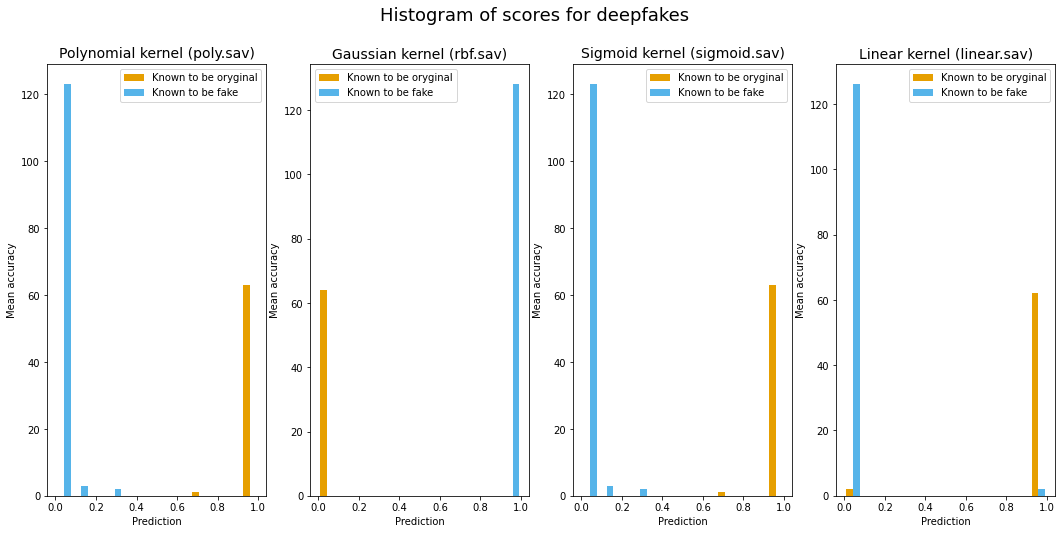

In [88]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
colors = ['#E69F00', '#56B4E9']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container_1 = []
    container_2 = []
    for k in results_2:
        container_1.append(k[i])
    for j in results_2_1:
        container_2.append(j[i])
    axes[i].hist([container_1, container_2], bins = int(180/15),
         color = colors, label = names)
    # Plot formatting
    axes[i].legend();
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('Histogram of scores for deepfakes', fontsize = 18);

### ROC curve of each model

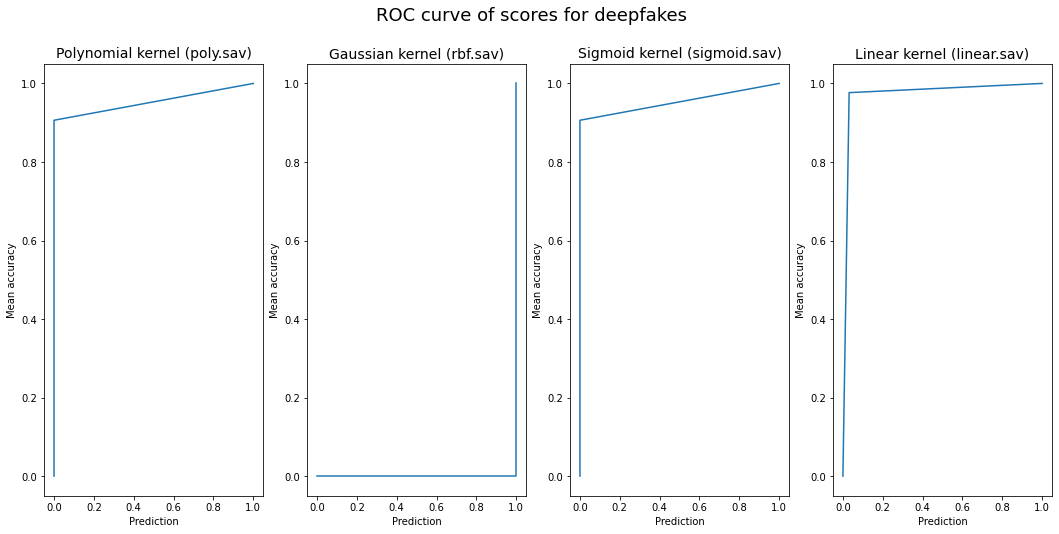

In [91]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container = list()
    results_2_2 = list()
    results_2_3 = list()
    for k in results_2:
        container.append(0)    # labels corresponding to fake videos
        results_2_2.append(k[i] == 0)    # 
    for j in results_2_1:
        container.append(1)    # labels corresponding to oryginal videos
        results_2_3.append(j[i] == 0)
    res = list(results_2_2 + results_2_3)
    fpr, tpr, _ = roc_curve(container, res)
    axes[i].plot(fpr, tpr)
    # plot formatting
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('ROC curve of scores for deepfakes', fontsize = 18);

## Selected 40 features

Second approach has been built with usage of **feature selection**. Fourty most valuable features were selected from the 105 set.

In [86]:
cols = [0, 1, 2, 3, 6, 9, 10, 11, 12, 13, 14, 15, 16, 
        17, 18, 19, 24, 25, 26, 27, 28, 29, 30, 31, 34, 
        36, 38, 39, 40, 41, 42, 43, 45, 47, 48, 51, 52, 53, 56, 60]    # choosen columns

In [53]:
results_2_1 = []
results_2 = []
for i in eval_videos:
    test_labels = list()
    result_1 = list()
    result_2 = list()
    hf = h5py.File(i, 'r')
    data = hf.get('features')[()]
    data = data[:, cols]
    (x, y) = data.shape
    if 'Deepfake' in i:
        for j in range(0, x):
            test_labels.append(0)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/second_classyfier_wth_selection(40features)/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_2.append(sc)    # appending fake videos
    else:
        for j in range(0, x):
            test_labels.append(1)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/second_classyfier_wth_selection(40features)/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_1.append(sc)    # appending oryginal videos
    if result_1 != []:
        results_2.append(result_1)
    else:
        results_2_1.append(result_2)

### Histogram of each model

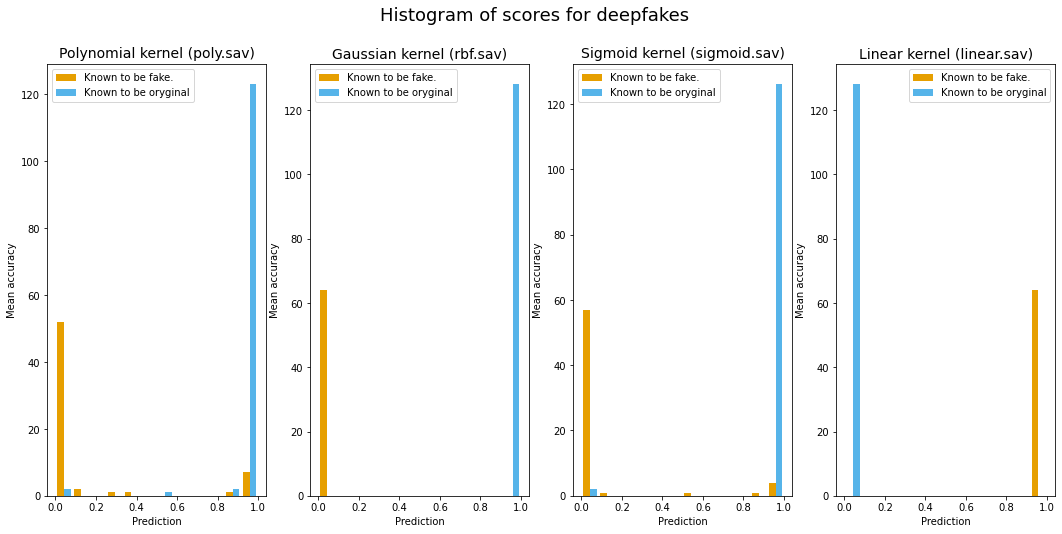

In [54]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
colors = ['#E69F00', '#56B4E9']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container_1 = []
    container_2 = []
    for k in results_2:
        container_1.append(k[i])
    for j in results_2_1:
        container_2.append(j[i])
    axes[i].hist([container_1, container_2], bins = int(180/15),
         color = colors, label = names)
    # Plot formatting
    axes[i].legend();
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('Histogram of scores for deepfakes', fontsize = 18);

### ROC curve of each model

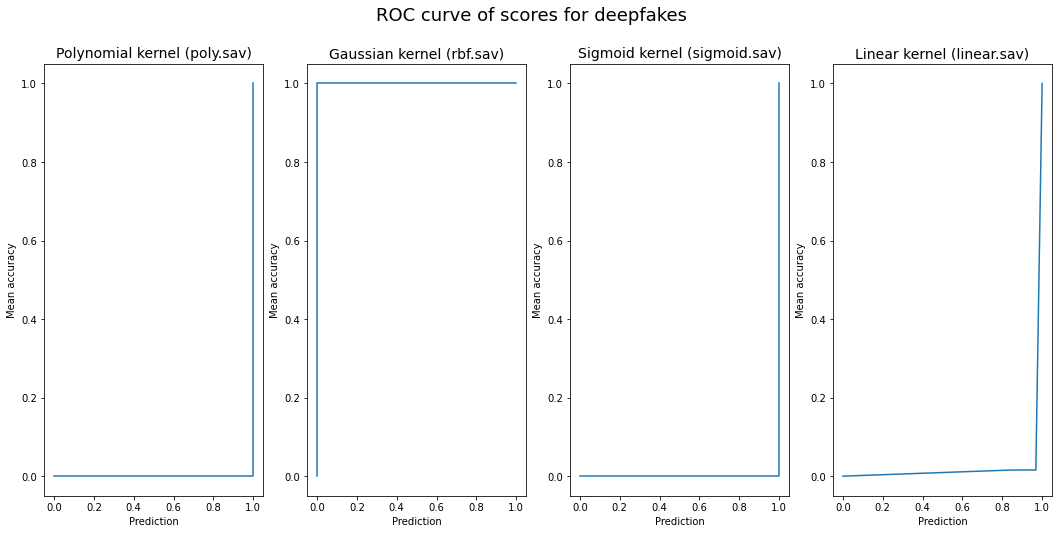

In [85]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container = list()
    results_2_2 = list()
    results_2_3 = list()
    for k in results_2:
        container.append(0)    # labels corresponding to fake videos
        results_2_2.append(k[i])
    for j in results_2_1:
        container.append(1)    # labels corresponding to oryginal videos
        results_2_3.append(j[i])
    res = list(results_2_2 + results_2_3)
    fpr, tpr, _ = roc_curve(container, res)
    axes[i].plot(fpr, tpr)
    # plot formatting
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('ROC curve of scores for deepfakes', fontsize = 18);

## Second model without features selection

And for comparison with first evaluation, after all those steps, first model was computed again.

In [69]:
results_2_1 = []
results_2 = []
for i in eval_videos:
    test_labels = list()
    result_1 = list()
    result_2 = list()
    hf = h5py.File(i, 'r')
    data = hf.get('features')[()]
    #mean_data = np.mean(data, axis = 0)
    #std_data = np.std(data, axis = 0)
    #data = (data - mean_data)/std_data    # normalize by removing mean and dividing by standard deviation
    (x, y) = data.shape
    if 'Deepfake' in i:
        for j in range(0, x):
            test_labels.append(0)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/second_classyfier_wthout_template_match/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_2.append(sc)    # appending fake videos
    else:
        for j in range(0, x):
            test_labels.append(1)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/second_classyfier_wthout_template_match/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_1.append(sc)    # appending oryginal videos
    if result_1 != []:
        results_2.append(result_1)
    else:
        results_2_1.append(result_2)

### Histogram of each model

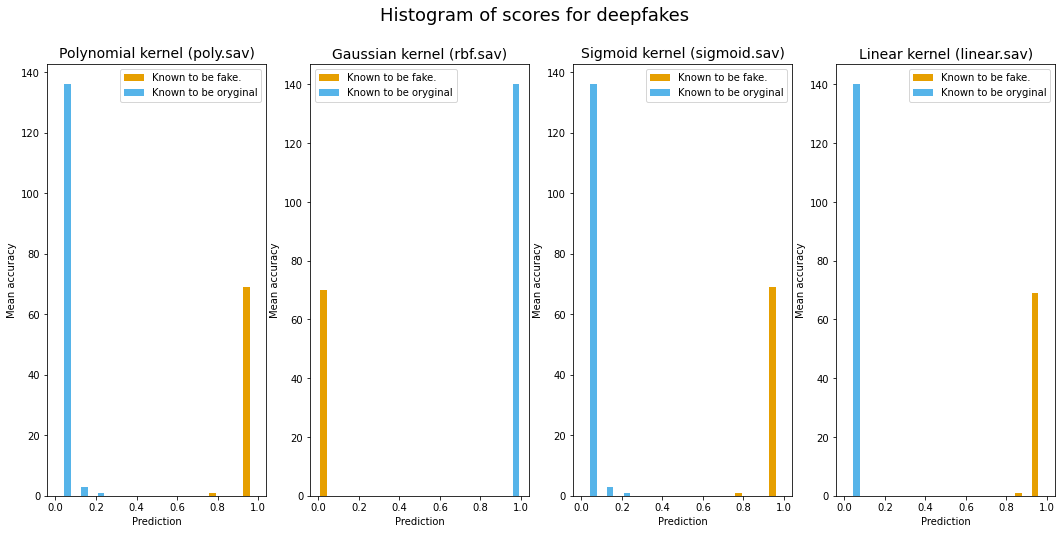

In [70]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
colors = ['#E69F00', '#56B4E9']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container_1 = []
    container_2 = []
    for k in results_2:
        container_1.append(k[i])
    for j in results_2_1:
        container_2.append(j[i])
    axes[i].hist([container_1, container_2], bins = int(180/15),
         color = colors, label = names)
    # Plot formatting
    axes[i].legend();
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('Histogram of scores for deepfakes', fontsize = 18);

### ROC curve of each model

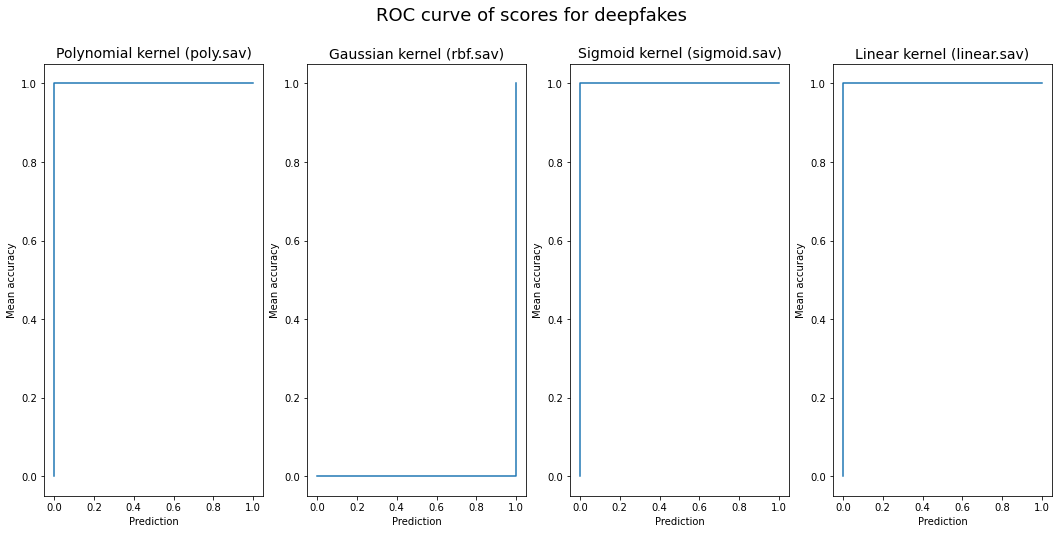

In [71]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container = list()
    results_2_2 = list()
    results_2_3 = list()
    for k in results_2:
        container.append(0)    # labels corresponding to fake videos
        results_2_2.append(k[i])
    for j in results_2_1:
        container.append(1)    # labels corresponding to oryginal videos
        results_2_3.append(j[i])
    res = list(results_2_2 + results_2_3)
    fpr, tpr, _ = roc_curve(container, res)
    axes[i].plot(fpr, tpr)
    # plot formatting
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('ROC curve of scores for deepfakes', fontsize = 18);

## Partition of training and evaluation videos as suggested by tutor (folderby) 

In [62]:
intersect = ['mccs0', 'mrjo0', 'fjem0', 'mdab0', 'mmdm2', 'fkms0', 'fdac1', 'mdbb0', 'mpgl0', 'mrcz0', 'msjs1', 'mgwt0', 'fjas0', 'mdld0', 'fjwb0', 'fcft0', 'mcem0', 'mwbt0', 'fjre0', 'mjsw0', 'faks0', 'mpdf0', 'fadg0', 'fdrd1', 'mmdb1', 'mstk0', 'fram1', 'mrgg0', 'fedw0', 'fcmh0', 'mjar0', 'felc0']
training_set = ['mccs0', 'mrjo0', 'fjem0', 'mdab0', 'mmdm2', 'fkms0', 'fdac1', 'mdbb0', 'mpgl0', 'mrcz0', 'msjs1', 'mgwt0', 'fjas0', 'mdld0', 'fjwb0', 'fcft0', 'mcem0', 'mwbt0', 'fjre0', 'mjsw0', 'faks0', 'mpdf0', 'fadg0', 'fdrd1', 'mmdb1']

In [64]:
pat = os.getcwd()    # getting the full path to actual folder
path = pat           # copy of path because in upyther recursion changes the oryginal
eval_videos = []


def getting_data(pat):
    global training_videos
    global eval_videos
    for filename in glob.iglob(pat+'/*',
                        recursive = True): 		# 1 (from Workflow list)
        if 'h5' in filename:					# 2 iteration over every frame in repository as desired in 2. of work flow
            if pat[-5:] in intersect and not pat[-5:] in training_set :
                eval_videos.append(filename)
            getting_data(filename)
        else:
            getting_data(filename)			# recursion if folder is not the desired one
getting_data(path) 
print('Number of evaluation videos: ', len(eval_videos))

Number of evaluation videos:  210


In [65]:
results_2_1 = []
results_2 = []
for i in eval_videos:
    test_labels = list()
    result_1 = list()
    result_2 = list()
    hf = h5py.File(i, 'r')
    data = hf.get('features')[()]
    #mean_data = np.mean(data, axis = 0)
    #std_data = np.std(data, axis = 0)
    #data = (data - mean_data)/std_data    # normalize by removing mean and dividing by standard deviation
    (x, y) = data.shape
    if 'Deepfake' in i:
        for j in range(0, x):
            test_labels.append(0)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/third_classyfier_wthout_selection/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_2.append(sc)    # appending fake videos
    else:
        for j in range(0, x):
            test_labels.append(1)
        for filename in filenames_1:
            loaded_model = pickle.load(open(os.getcwd()+'/third_classyfier_wthout_selection/'+ filename, 'rb'))
            sc = loaded_model.score(data, test_labels)
            result_1.append(sc)    # appending oryginal videos
    if result_1 != []:
        results_2.append(result_1)
    else:
        results_2_1.append(result_2)

In [66]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

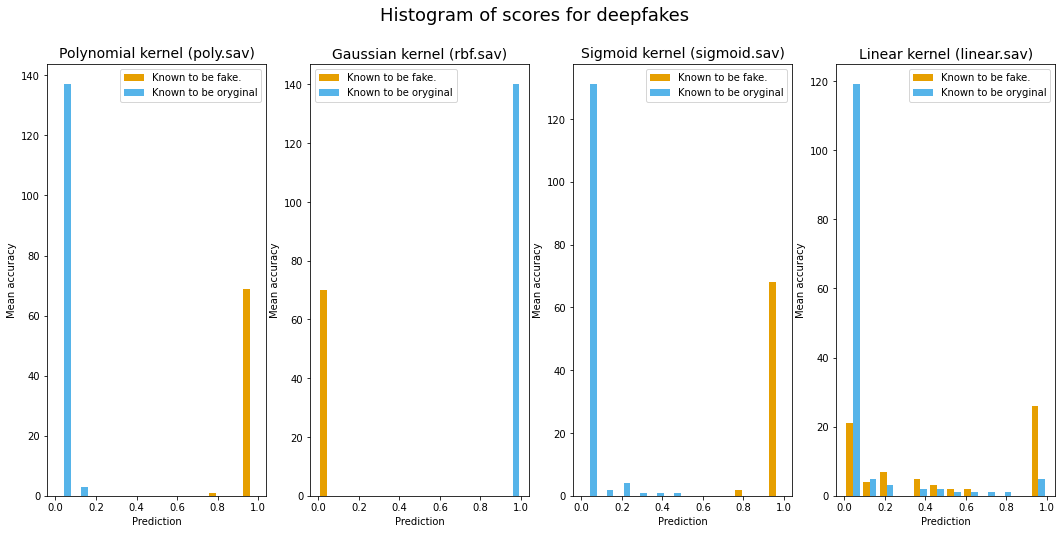

In [67]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
colors = ['#E69F00', '#56B4E9']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container_1 = []
    container_2 = []
    for k in results_2:
        container_1.append(k[i])
    for j in results_2_1:
        container_2.append(j[i])
    axes[i].hist([container_1, container_2], bins = int(180/15),
         color = colors, label = names)
    # Plot formatting
    axes[i].legend();
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('Histogram of scores for deepfakes', fontsize = 18);

## Receiver Operating Characteristics curve

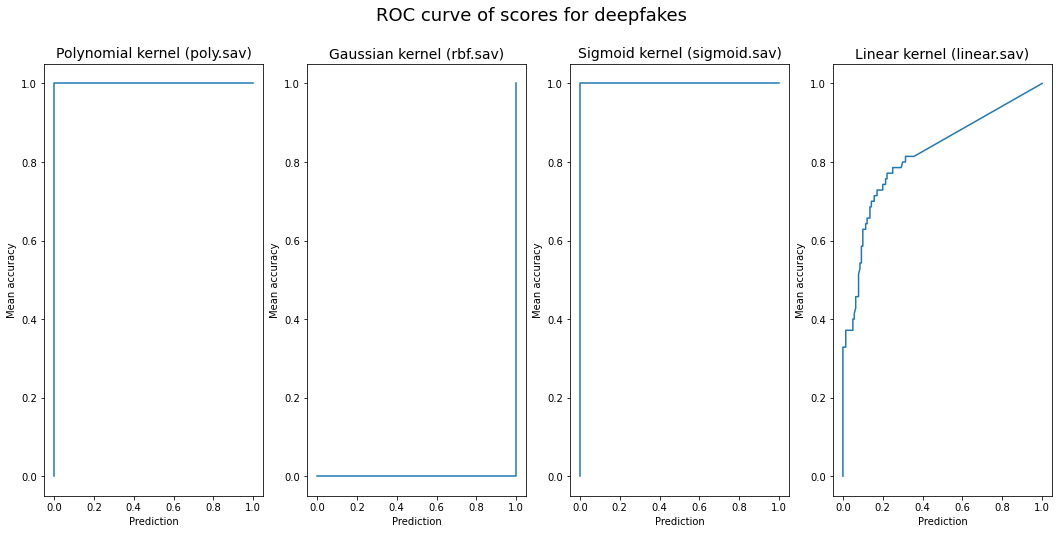

In [68]:
fig, (ax1, ax2, ax3, a4) = plt.subplots(1, 4)
axes = [ax1, ax2, ax3, a4]
titles = ['Polynomial kernel (poly.sav)', 'Gaussian kernel (rbf.sav)', 'Sigmoid kernel (sigmoid.sav)', 'Linear kernel (linear.sav)']
names = ['Known to be oryginal', 'Known to be fake']
for i in range(len(axes)):
    container = list()
    results_2_2 = list()
    results_2_3 = list()
    for k in results_2:
        container.append(0)    # labels corresponding to fake videos
        results_2_2.append(k[i])
    for j in results_2_1:
        container.append(1)    # labels corresponding to oryginal videos
        results_2_3.append(j[i])
    res = list(results_2_2 + results_2_3)
    fpr, tpr, _ = roc_curve(container, res)
    axes[i].plot(fpr, tpr)
    # plot formatting
    axes[i].set_xlabel('Prediction');
    axes[i].set_ylabel('Mean accuracy');
    set_size(14,6,axes[i])
    axes[i].set_title(titles[i], fontsize = 14)
fig.suptitle('ROC curve of scores for deepfakes', fontsize = 18);